In [1]:
import tensorflow as tf
# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-08-29 22:48:08.050553


### Using a GPU

In [2]:
!nvidia-smi

Tue Aug 29 22:48:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-08-29 22:50:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 142.251.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  33.6MB/s    in 5.2s    

2023-08-29 22:50:18 (30.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

## Creating data loaders (preparing the data)

#### Now we've downloaded the data, let's use the ImageDataGenerator class along with the flow_from_directory method to load in our images.

In [14]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training Images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                       target_size = IMAGE_SHAPE,
                                                       batch_size = BATCH_SIZE,
                                                       class_mode = "categorical")
print("Testing Images")
test_data= test_datagen.flow_from_directory(test_dir,
                                                        target_size = IMAGE_SHAPE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = "categorical")

Training Images
Found 750 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class).

## Setting up callbacks

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

- we'll use TensorBoard callback

- The TensorBoard callback can be accessed using `tf.keras.callbacks.TensorBoard()`.

- Its main functionality is saving a model's training performance metrics to a specified `log_dir`.

- By default, logs are recorded every epoch using the `update_freq='epoch`' parameter. This is a good default since tracking model performance too often can slow down model training.

In [16]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

our function saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`, where:

- `dir_name` is the overall logs directory
- `experiment_name` is the particular experiment
- `current_timestamp` is the time the experiment started based on Python's `atetime.datetime().now()`

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from [TensorFlow Hub](https://tfhub.dev/).

In fact, we're going to use two models from TensorFlow Hub:

- ResNetV2 - a state of the art computer vision model architecture from 2016.
- EfficientNet - a state of the art computer vision architecture from 2019.

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

These URLs link to a saved pretrained model on TensorFlow Hub.

Since we're going to be comparing two models, to save ourselves code, we'll create a function create_model(). This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model.

In [12]:
def create_model(model_url, num_classes = 10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False, # freeze the underlying patterns
                                           name = 'feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = 'softmax', name = 'ouput_layer') # create our own output layer
  ])

  return model

The model is instantiated, we'll compile it using categorical_crossentropy as our loss function, the Adam optimizer and accuracy as our metric.

In [13]:
# Create model
resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [18]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files)

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230829-231950
Epoch 1/5
24/24 [==============================] - 28s 564ms/step - loss: 2.0328 - accuracy: 0.3187 - val_loss: 1.2553 - val_accuracy: 0.5876
Epoch 2/5
24/24 [==============================] - 22s 929ms/step - loss: 0.9347 - accuracy: 0.7333 - val_loss: 0.8705 - val_accuracy: 0.7260
Epoch 3/5
24/24 [==============================] - 11s 477ms/step - loss: 0.6329 - accuracy: 0.8280 - val_loss: 0.7510 - val_accuracy: 0.7668
Epoch 4/5
24/24 [==============================] - 13s 550ms/step - loss: 0.4895 - accuracy: 0.8747 - val_loss: 0.7037 - val_accuracy: 0.7836
Epoch 5/5
24/24 [==============================] - 11s 470ms/step - loss: 0.3848 - accuracy: 0.9133 - val_loss: 0.6763 - val_accuracy: 0.7920


Achieving around 90% accuracy on the training set and nearly 90% accuracy on the test set...with only 10 percent of the training images!

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

Let's check out our model's training curves using our plot_loss_curves function.

In [19]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

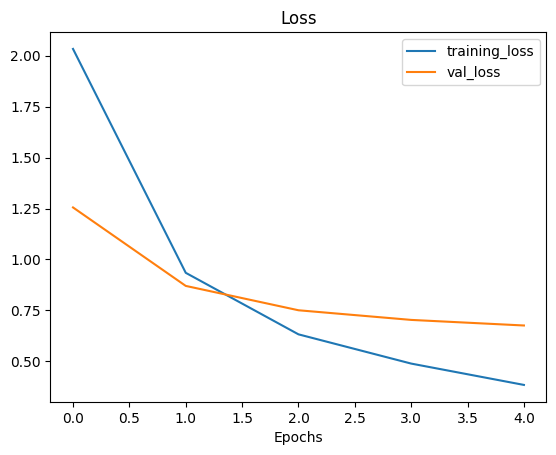

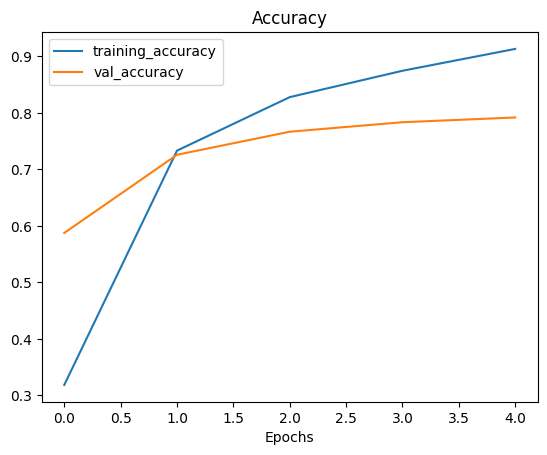

In [20]:
plot_loss_curves(resnet_history)

In [21]:
# Resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 ouput_layer (Dense)         (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [22]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230829-232820
Epoch 1/5
24/24 [==============================] - 21s 548ms/step - loss: 2.0529 - accuracy: 0.2973 - val_loss: 1.5823 - val_accuracy: 0.5944
Epoch 2/5
24/24 [==============================] - 10s 432ms/step - loss: 1.3472 - accuracy: 0.6720 - val_loss: 1.1580 - val_accuracy: 0.7128
Epoch 3/5
24/24 [==============================] - 13s 540ms/step - loss: 1.0280 - accuracy: 0.7587 - val_loss: 0.9669 - val_accuracy: 0.7444
Epoch 4/5
24/24 [==============================] - 10s 435ms/step - loss: 0.8584 - accuracy: 0.7907 - val_loss: 0.8672 - val_accuracy: 0.7652
Epoch 5/5
24/24 [==============================] - 10s 427ms/step - loss: 0.7481 - accuracy: 0.8213 - val_loss: 0.8041 - val_accuracy: 0.7696


The EfficientNetB0 model does even better than the ResNetV250 model! Achieving over 80% accuracy on the test set...again with only 10% of the training data.

With a couple of lines of code we're able to leverage state of the art models and adjust them to our own use case.

Let's check out the loss curves.

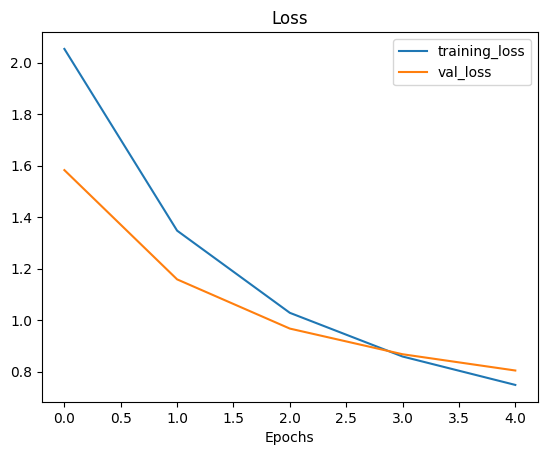

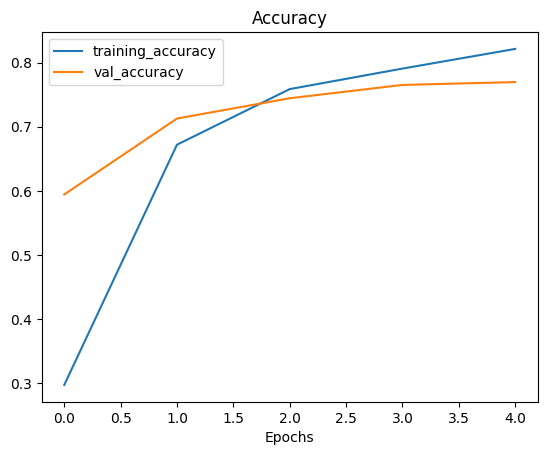

In [23]:
plot_loss_curves(efficientnet_history)

In [24]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             5919312   
 erasLayer)                                                      
                                                                 
 ouput_layer (Dense)         (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


# Comparing models using TensorBoard

## Uploading experiments to TensorBoard

- --logdir is the target upload directory
- --name is the name of the experiment
- --description is a brief description of the experiment
- --one_shot exits the TensorBoard uploader once uploading is finished

In [25]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-08-29 23:31:42.656643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   GPK-RYR-SNF



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

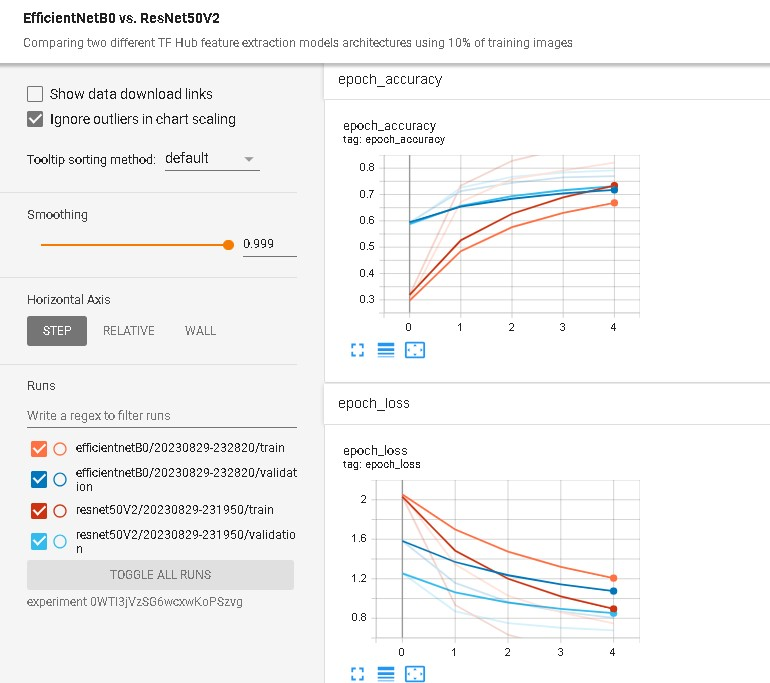